# Other scaling
> Effect of number of samples, max depth, number of trees, and number of dimensions on runtime

In [14]:
%load_ext autoreload
%autoreload 2

In [15]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from time import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier

from hyperdt.forest import HyperbolicRandomForestClassifier
from hyperdt.toy_data import wrapped_normal_mixture

In [16]:
# Global hyperparams
N_DIM = 2
NUM_CLASSES = 5
NUM_POINTS = 1000
MAX_DEPTH = 3
N_ESTIMATORS = 12
N_TRIALS = 20
TEST_SIZE = 0.2

# ==== IMPORTANT =====
FORCE_RETRAIN = False

In [17]:
# Matplotlib figure  stuff

plt.rcParams.update({"font.size": 20})
plt.rc("axes", titlesize=20)
plt.rc("axes", labelsize=20)
plt.rc("xtick", labelsize=16)
plt.rc("ytick", labelsize=16)
plt.rc("legend", fontsize=16)

In [18]:
# Master code for experiment


def run_experiment(param_name, param_min, param_max, step):
    path = f"../data/processed/supplement_benchmarks/{param_name}_results.csv"
    if os.path.exists(path) and not FORCE_RETRAIN:
        results = pd.read_csv(path)

    else:
        results = pd.DataFrame(columns=[param_name, "trial", "time", "f1-micro"])
        param_range = range(param_min, param_max, step)
        my_tqdm = tqdm(total=len(param_range) * N_TRIALS)

        for param_value in param_range:
            for trial in range(N_TRIALS):
                # Data kwargs
                data_kwargs = {"num_points": NUM_POINTS, "num_classes": NUM_CLASSES, "n_dim": N_DIM, "seed": trial}
                if param_name in data_kwargs:
                    data_kwargs[param_name] = param_value

                # Generate data - not timed
                X, y = wrapped_normal_mixture(**data_kwargs)
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=trial)

                t1 = time()

                # Classifier kwargs
                clf_kwargs = {
                    "n_estimators": N_ESTIMATORS,
                    "max_depth": MAX_DEPTH,
                    "random_state": trial,
                    "skip_hyperboloid_check": True,
                }
                if param_name in clf_kwargs:
                    clf_kwargs[param_name] = param_value

                # Fit and predict (timed)
                try:
                    clf = HyperbolicRandomForestClassifier(**clf_kwargs)
                    clf.fit(X_train, y_train)
                    y_pred = clf.predict(X_test)

                    t2 = time()

                    # Save results
                    score = f1_score(y_test, y_pred, average="micro")
                    results.loc[len(results)] = {
                        param_name: param_value,
                        "trial": trial,
                        "time": t2 - t1,
                        "f1-micro": score,
                    }
                except Exception as e:
                    print(f"Failed for {param_name}={param_value}, trial={trial}")
                    print(e)
                my_tqdm.update(1)

        results.to_csv(path, index=False)

    return results

In [21]:
# Plotting function


def plot_results(df, col, ax=None, fill="ci"):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))

    means = df.groupby(col).mean().reset_index()
    stderr = df.groupby(col).std().reset_index() / np.sqrt(N_TRIALS)

    ax.plot(means[col], means["time"], color="blue", label="Training time", lw=4)
    # ax.fill_between(means[col], means["time"] - stds["time"], means["time"] + stds["time"], alpha=0.2)
    ax.fill_between(
        means[col],
        means["time"] - 1.96 * stderr["time"],
        means["time"] + 1.96 * stderr["time"],
        color="blue",
        alpha=0.2,
    )
    ax.set_ylabel("Training time (s)")
    h1, l1 = ax.get_legend_handles_labels()
    ax.set_ylim(0, np.max(means["time"] + 1.96 * stderr["time"]))

    ax2 = ax.twinx()

    ax2.plot(means[col], means["f1-micro"], color="orange", label="F1-micro", lw=4)
    ax2.fill_between(
        means[col],
        means["f1-micro"] - 1.96 * stderr["f1-micro"],
        means["f1-micro"] + 1.96 * stderr["f1-micro"],
        color="orange",
        alpha=0.2,
    )
    ax2.set_ylabel("F1-micro")
    h2, l2 = ax2.get_legend_handles_labels()
    ax2.legend(h1 + h2, l1 + l2)
    ax2.set_ylim(0, np.max(means["f1-micro"] + 1.96 * stderr["f1-micro"]))

    return ax, ax2

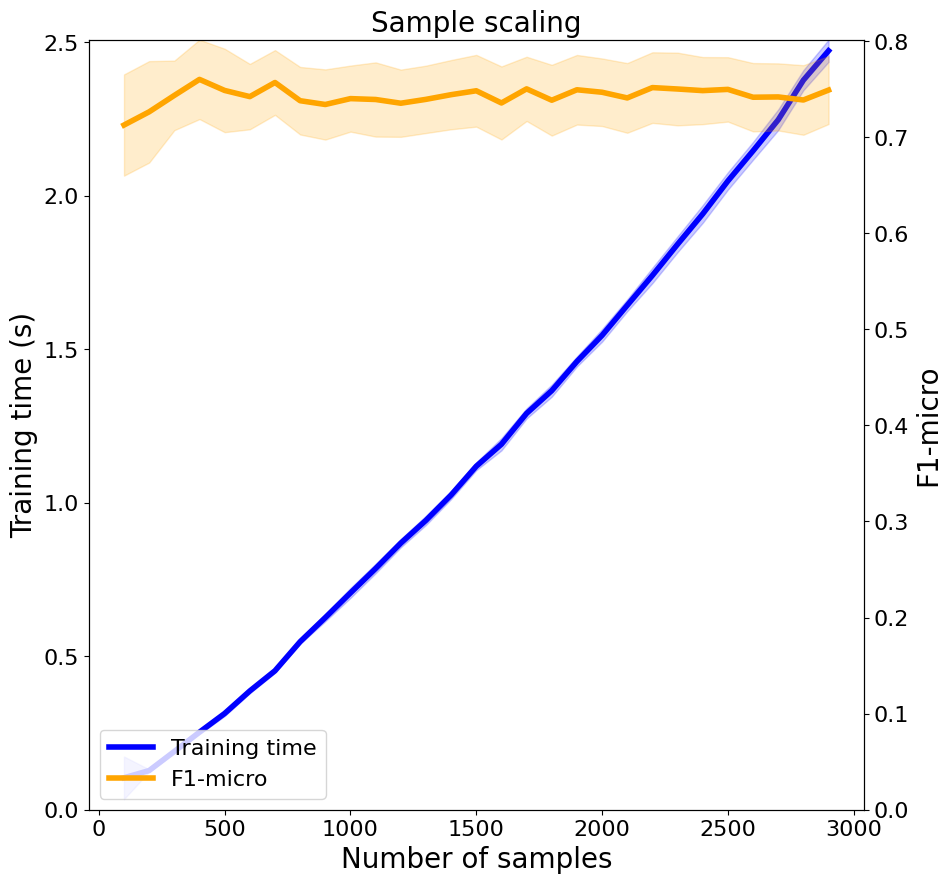

In [22]:
# Experiment 1: #samples

# # Hyperparams
MIN_SAMPLES = 100
MAX_SAMPLES = 3000
STEP = 100

# Results
n_samples_results = run_experiment("num_points", MIN_SAMPLES, MAX_SAMPLES, STEP)

# Plotting
ax, ax2 = plot_results(n_samples_results, "num_points")
ax.set_xlabel("Number of samples")
ax.set_title("Sample scaling")
plt.show()

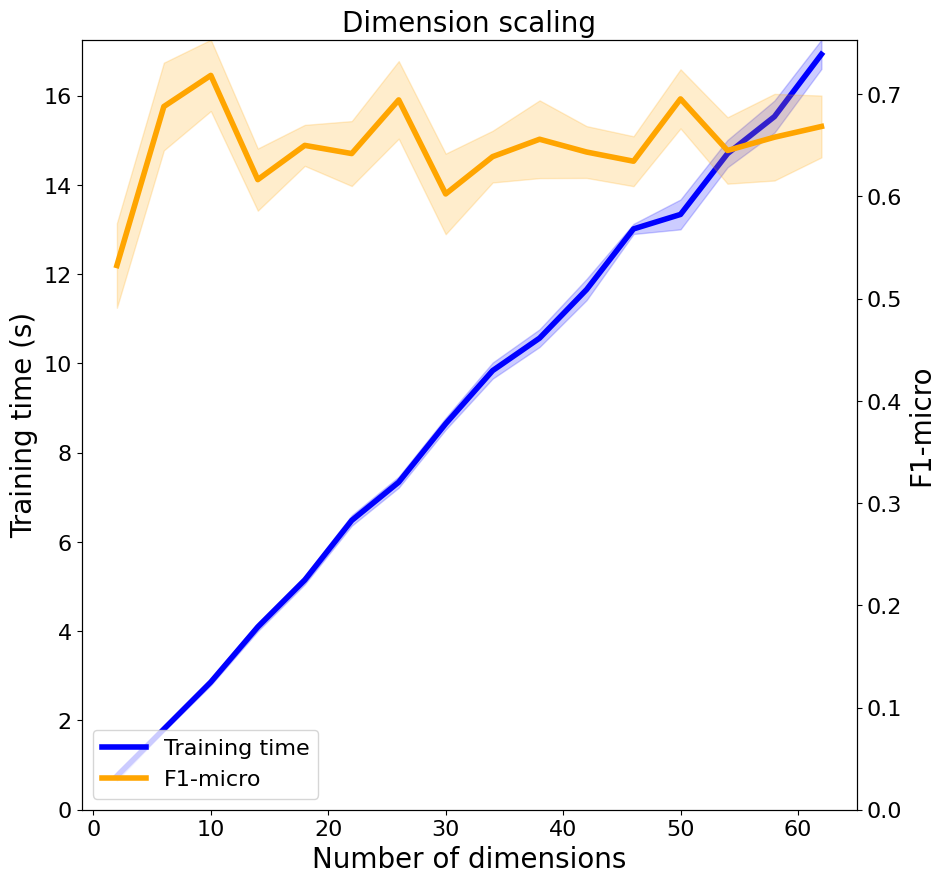

In [27]:
# Experiment 2: #dimensions

# Hyperparams
MIN_DIMS = 2
MAX_DIMS = 64
STEP = 2

# Experiment
n_dims_results = run_experiment("n_dim", MIN_DIMS, MAX_DIMS, STEP)

# Plotting
ax, ax2 = plot_results(n_dims_results, "n_dim")
ax.set_xlabel("Number of dimensions")
ax.set_title("Dimension scaling")
plt.show()

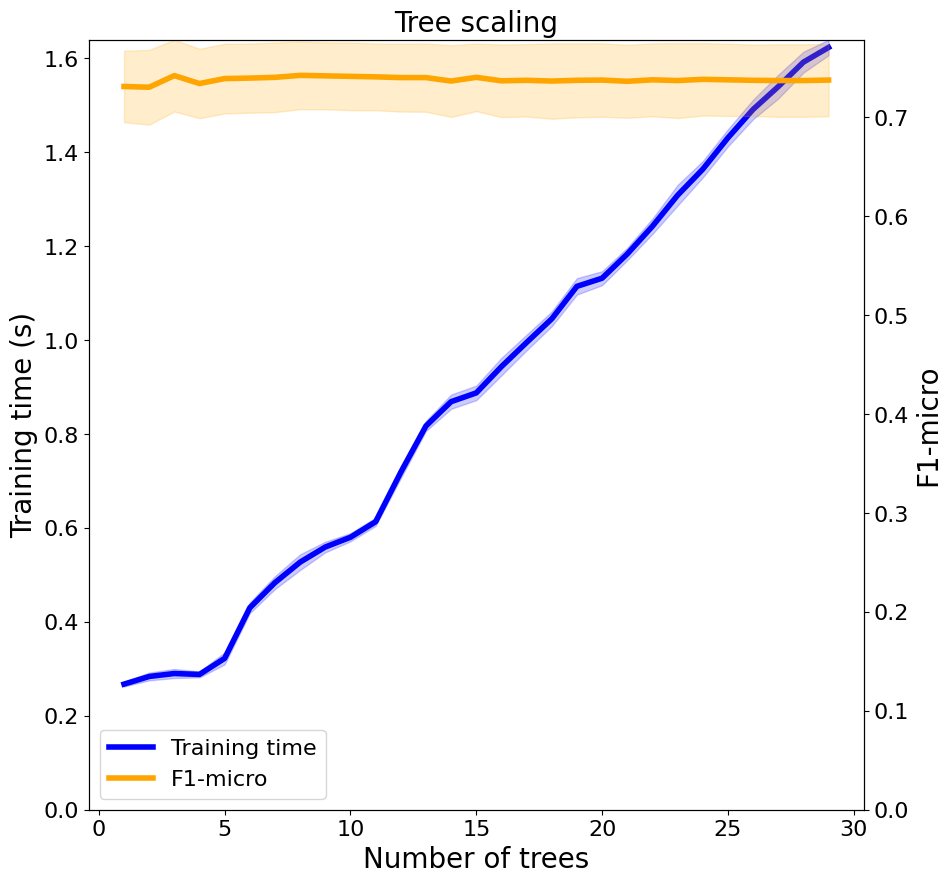

In [28]:
# Experiment 3: number of trees

# Hyperparams
MIN_TREES = 1
MAX_TREES = 30
STEP = 1

# Experiment
n_trees_results = run_experiment("n_estimators", MIN_TREES, MAX_TREES, STEP)

# Plotting
ax, ax2 = plot_results(n_trees_results, "n_estimators")
ax.set_xlabel("Number of trees")
ax.set_title("Tree scaling")
plt.show()

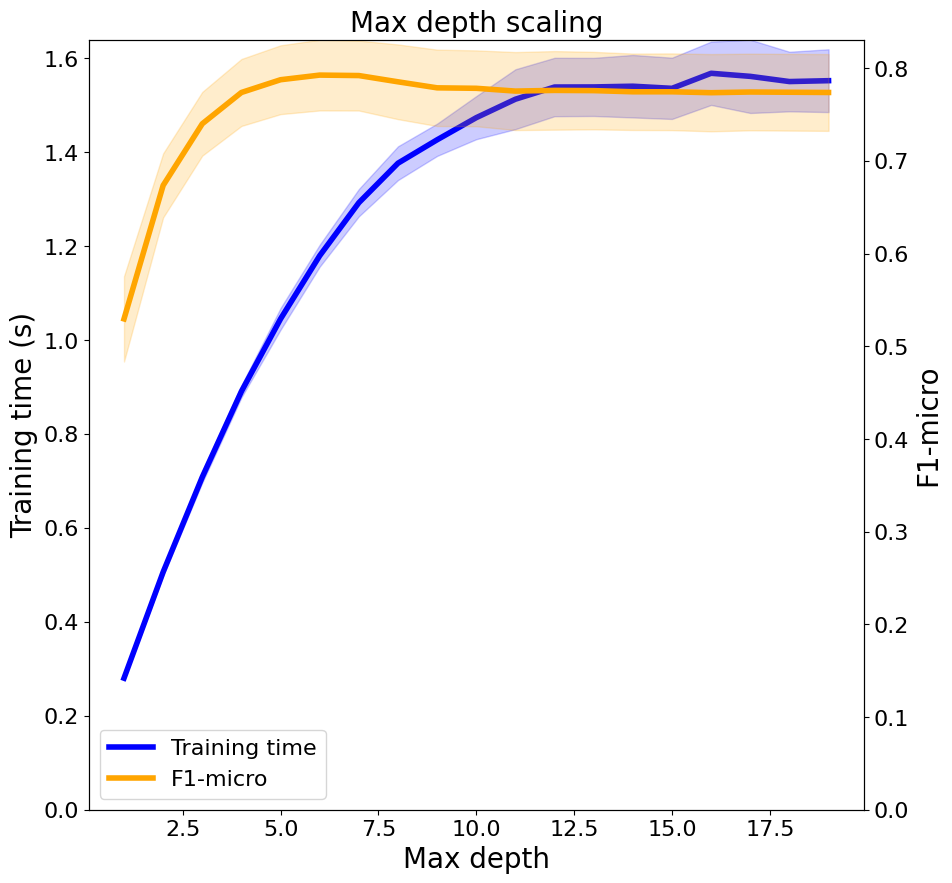

In [29]:
# Experiment 4: max depth

# Hyperparams
MIN_DEPTH = 1
MAX_DEPTH = 20
STEP = 1

# Results
max_depth_results = run_experiment("max_depth", MIN_DEPTH, MAX_DEPTH, STEP)

# Plotting
ax, ax2 = plot_results(max_depth_results, "max_depth")
ax.set_xlabel("Max depth")
ax.set_title("Max depth scaling")
plt.show()

# Depth experiment

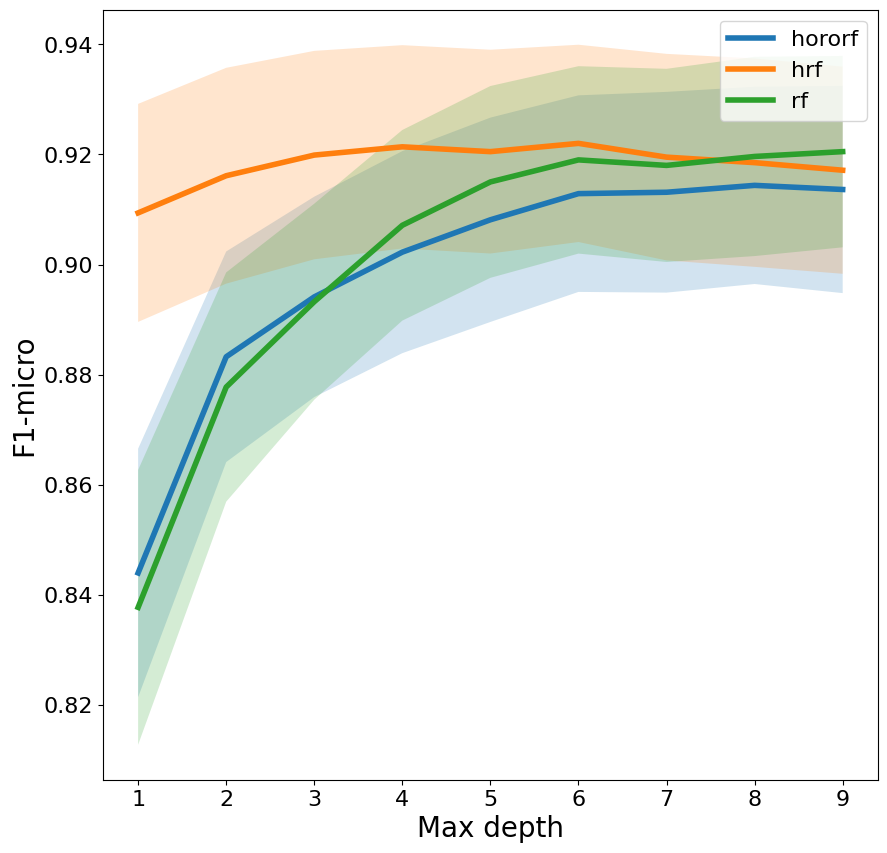

In [37]:
# I decided to factor out this code to the script `maxdepth_benchmarks.py`
# Results are in data/processed/depth_benchmark

big_depth_results = pd.read_table("../data/processed/depth_benchmark/hororf_results.tsv")
big_depth_times = pd.read_table("../data/processed/depth_benchmark/hororf_times.tsv")

# Merge
big_depth_results = big_depth_results.merge(big_depth_times, on=["max_depth", "seed", "clf"])

# Plot accuracies
means = big_depth_results.groupby(["max_depth", "clf"]).mean().reset_index()
stderr = big_depth_results.groupby(["max_depth", "clf"]).std() / np.sqrt(N_TRIALS)
stderr = stderr.reset_index()

fig, ax = plt.subplots(figsize=(10, 10))
for clf in means["clf"].unique():
    ax.plot(means[means["clf"] == clf]["max_depth"], means[means["clf"] == clf]["f1_micro"], label=clf, lw=4)
    means_clf = means[means["clf"] == clf]
    stderr_clf = stderr[stderr["clf"] == clf]
    ax.fill_between(
        means_clf["max_depth"],
        means_clf["f1_micro"] - stderr_clf["f1_micro"],
        means_clf["f1_micro"] + stderr_clf["f1_micro"],
        alpha=0.2,
    )

# ax.set_ylim(0.5, 1)
ax.set_xlabel("Max depth")
ax.set_ylabel("F1-micro")
ax.legend()